In [1]:
import matplotlib.pyplot as plt

import tensorflow as tf

import numpy as np
import os
import time
import imageio.v2 as imageio
import glob

from IPython import display

from PIL import Image

In [2]:
img_size = 64

In [3]:
face_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "./images",
    labels="inferred",
    label_mode="int",
    class_names=['anime_faces'],
    color_mode="grayscale",
    batch_size=32,
    image_size=(img_size, img_size),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
)

Found 63565 files belonging to 1 classes.


In [4]:
n = 2000

In [5]:
face_train_images = []
face_train_labels = []

k = 0

for images, labels in face_dataset:
    for i in range(len(images)):
        face_train_images.append(images[i])
        face_train_labels.append(labels[i])
        k += 1
        if k == n:
            break
    if k == n:
        break
face_train_images = face_train_images[:n]
face_train_labels = face_train_labels[:n]

In [6]:
c_images = np.array(face_train_images)
print(c_images.shape)
c_images = c_images.reshape(c_images.shape[0], img_size, img_size)
print(c_images.shape)

(2000, 64, 64, 1)
(2000, 64, 64)


In [7]:
c_labels = np.array(face_train_labels)
print(c_labels.shape)
c_labels = c_labels.reshape(c_labels.shape[0], )
print(c_labels.shape)

(2000,)
(2000,)


In [8]:
train_images = c_images
train_labels = c_labels

In [9]:
train_images = train_images.reshape(train_images.shape[0], img_size, img_size, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [10]:
BUFFER_SIZE = 40000
BATCH_SIZE = 256

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
x = img_size // 8


def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(x * x * 256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((x, x, 256)))
    assert model.output_shape == (None, x, x, 256)  # Note: None is the batch size

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, x, x, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 2 * x, 2 * x, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(
        tf.keras.layers.Conv2DTranspose(1, (10, 10), strides=(4, 4), padding='same', use_bias=False, activation='tanh'))
    print(model.output_shape)
    assert model.output_shape == (None, img_size, img_size, 1)  #generator model
    return model

In [13]:
make_generator_model().summary()

(None, 64, 64, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8

(None, 64, 64, 1)
tf.Tensor(
[[ 1.17301226e+00  4.00850996e-02 -7.55876720e-01 -3.81922990e-01
  -3.63397419e-01 -7.85348117e-01  1.33959770e+00  7.93395996e-01
  -8.48771811e-01  1.02403797e-01  2.46710777e+00 -2.92633921e-01
  -4.80084956e-01 -5.05912874e-04  1.64793062e+00  1.15317607e+00
  -1.65600860e+00  9.15073991e-01  1.57767069e+00 -2.28563279e-01
   1.84594050e-01 -2.09585771e-01 -2.57945210e-01 -6.86773956e-02
   9.21865582e-01  1.03396907e-01 -2.16257381e+00  8.94896924e-01
  -4.98222783e-02 -7.75885701e-01  2.64084727e-01 -5.34748673e-01
  -3.43654990e-01 -1.50344527e+00  1.46965817e-01 -1.98333338e-01
  -2.85261065e-01  7.97631741e-01 -3.96253675e-01  9.28752571e-02
  -1.44703102e+00  8.09846520e-01 -9.88307238e-01  7.40291595e-01
  -7.58473217e-01 -8.17771927e-02 -2.69735336e-01  1.02627528e+00
  -7.51455307e-01 -1.25743890e+00  1.45505333e+00  7.70653605e-01
  -1.61603487e+00  4.87614483e-01 -2.15652347e-01  1.76605725e+00
   6.35581076e-01  1.25090897e+00  1.14303637e+

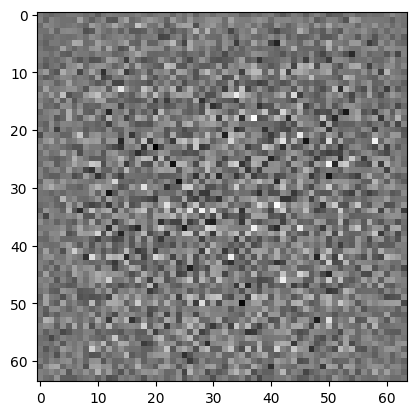

In [14]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
print(noise)
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [15]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (8, 8), strides=(2, 2), padding='same', input_shape=(img_size, img_size, 1)))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(64, (16, 16), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

In [16]:
make_discriminator_model().summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        2080      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        524352    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 flatten (Flatten)           (None, 16384)            

In [17]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00168183]], shape=(1, 1), dtype=float32)


In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [19]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [22]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [23]:
EPOCHS = 250
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [24]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [25]:
def train(dataset, epochs):
    t = 0
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        t += time.time() - start

        print('Time for epoch {} is {} sec'.format(epoch + 1, round(time.time() - start, 2)))
        print(f"Total time : {round(t, 2)} sec")

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [26]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('images_out/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

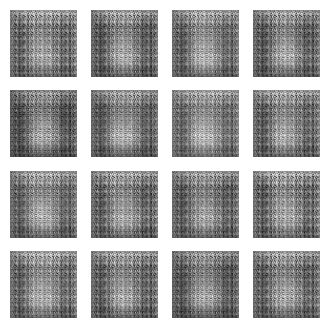

Time for epoch 9 is 26.82 sec
Total time : 238.59 sec


In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
generator.evaluate(train_images[:n])

In [ ]:
generator.save('saved_model/generator_model_new')

In [ ]:
gen_seed = tf.random.normal([num_examples_to_generate, noise_dim])
generate_and_save_images(generator, 2000, gen_seed)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return Image.open('images_out/image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

In [ ]:
png_dir = 'images_out'
images = []

for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))

# Make it pause at the end so that the viewers can ponder
for _ in range(10):
    images.append(imageio.imread(file_path))

imageio.mimsave('movie.gif', images)

In [ ]:
savedModel = tf.saved_model.load("saved_model/generator_model_new")
savedModel.summary()